<a href="https://colab.research.google.com/github/AdityaGhatty/Datascience/blob/main/DiwaliEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression with outside_range variable and no week_0:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     48.44
Date:                Sat, 12 Oct 2024   Prob (F-statistic):          3.34e-278
Time:                        16:19:45   Log-Likelihood:                -46933.
No. Observations:                5000   AIC:                         9.394e+04
Df Residuals:                    4965   BIC:                         9.417e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

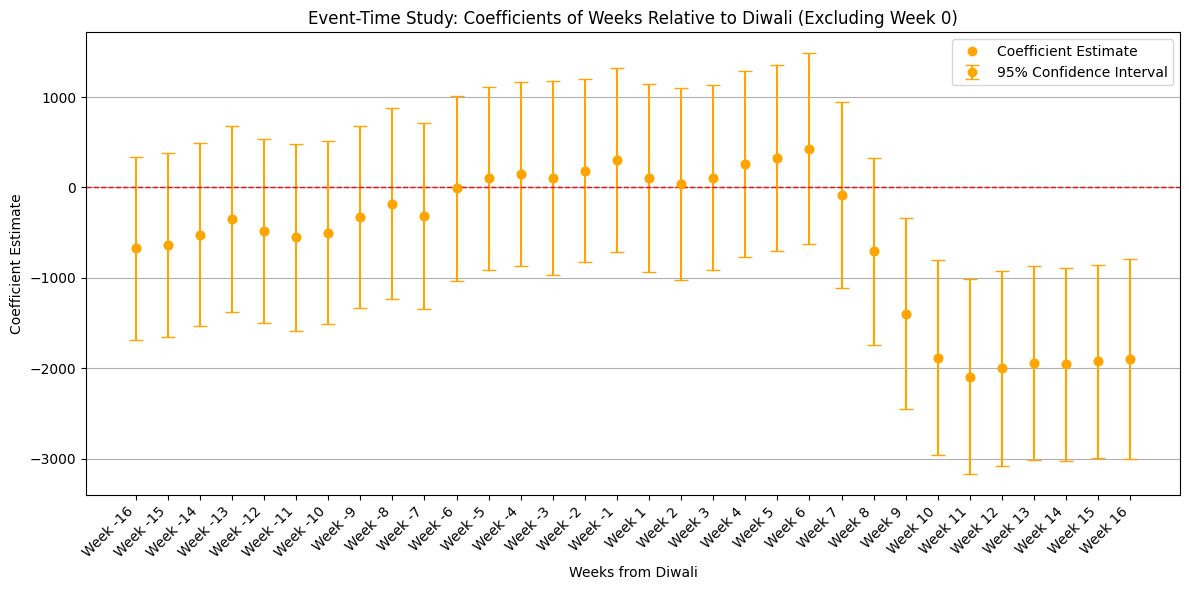

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the CSV data
url_N50HD = 'https://raw.githubusercontent.com/AdityaGhatty/Datascience/refs/heads/main/Nifty%2050%20Historical%20Data.csv'
N50 = pd.read_csv(url_N50HD)

# Convert 'Date' column to datetime
N50['Date'] = pd.to_datetime(N50['Date'], errors='coerce')

# Function to convert strings with 'M' or 'B' to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        if 'M' in value:
            return float(value.replace('M', '').replace(',', '').strip()) * 1e6
        elif 'B' in value:
            return float(value.replace('B', '').replace(',', '').strip()) * 1e9
        elif '%' in value:  # Handle percentage values
            return float(value.replace('%', '').strip()) / 100  # Convert to decimal
        else:
            return float(value.replace(',', '').strip())
    return value

# Remove commas from numeric columns and convert to numeric
numeric_columns = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
for col in numeric_columns:
    N50[col] = N50[col].apply(convert_to_numeric)

# Rename 'Price' to 'Close' for clarity
N50.rename(columns={'Price': 'Close'}, inplace=True)

# List of Diwali dates
diwali_dates = ['2007-11-09', '2008-10-28', '2009-10-17', '2010-11-05',
                '2011-10-26', '2012-11-13', '2013-11-03', '2014-10-23',
                '2015-11-11', '2016-10-30', '2017-10-19', '2018-11-07',
                '2019-10-27', '2020-11-14', '2021-11-04']

# Convert Diwali dates to datetime objects
diwali_dates = pd.to_datetime(diwali_dates)

# Create a DataFrame to hold the week dummy variables
dummy_data = []

# Loop through each row in the DataFrame
for index, row in N50.iterrows():
    # Find the nearest Diwali date
    nearest_diwali = min(diwali_dates, key=lambda x: abs(x - row['Date']))
    distance_weeks = (row['Date'] - nearest_diwali).days // 7  # Distance in weeks

    # Check if the date is outside the 16-week range
    outside_range = 1 if distance_weeks < -16 or distance_weeks > 16 else 0

    # Create dummies for weeks before and after Diwali, excluding week zero
    week_dummies = {f'week_{i}': 1 if distance_weeks == i else 0 for i in range(-16, 17) if i != 0}

    # Create the dummy row
    dummy_row = {
        'Date': row['Date'],
        'Close': row['Close'],
        'outside_range': outside_range,
        **week_dummies
    }
    dummy_data.append(dummy_row)

# Create a DataFrame from the dummy data
dummy_df = pd.DataFrame(dummy_data)

# Create a month variable
dummy_df['Month'] = dummy_df['Date'].dt.month

# Prepare the regression data
X = dummy_df.drop(columns=['Date', 'Close'])  # Independent variables
X = X.astype(int)  # Convert boolean to integers
y = dummy_df['Close']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Run the regression with the updated variables
model = sm.OLS(y, X).fit()

# Print the regression results
print("Regression with outside_range variable and no week_0:")
print(model.summary())

# Extract coefficients for the week dummy variables for plotting
# We exclude the first two entries, which are the constant and 'outside_range'
coefficients = model.params[2:34]  # Adjust the range to match the week dummy variables
confidence_intervals = model.conf_int()[2:34]  # Get the confidence intervals for the same range

# Create the week labels from -16 to +16, excluding 0 (32 weeks in total)
week_labels = [f"Week {i}" for i in range(-16, 17) if i != 0]

# Check to ensure the number of labels matches the number of coefficients
if len(coefficients) == len(week_labels):
    # Create a plot for the coefficients with confidence intervals
    plt.figure(figsize=(12, 6))

    # Plot the coefficients as points
    plt.plot(week_labels, coefficients, 'o', color='orange', label='Coefficient Estimate')

    # Plot the confidence intervals as vertical error bars
    plt.errorbar(week_labels, coefficients,
                 yerr=[coefficients - confidence_intervals[0], confidence_intervals[1] - coefficients],
                 fmt='o', color='orange', capsize=5, label='95% Confidence Interval')

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal line at y=0
    plt.title('Event-Time Study: Coefficients of Weeks Relative to Diwali (Excluding Week 0)')
    plt.xlabel('Weeks from Diwali')
    plt.ylabel('Coefficient Estimate')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.legend()
    plt.show()
else:
    print("Mismatch in the number of week labels and coefficients. Please check the regression model output.")

Regression with month variables, year variable, outside_range, and no week_0:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     2253.
Date:                Sat, 12 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:27:53   Log-Likelihood:                -40584.
No. Observations:                5000   AIC:                         8.124e+04
Df Residuals:                    4964   BIC:                         8.147e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

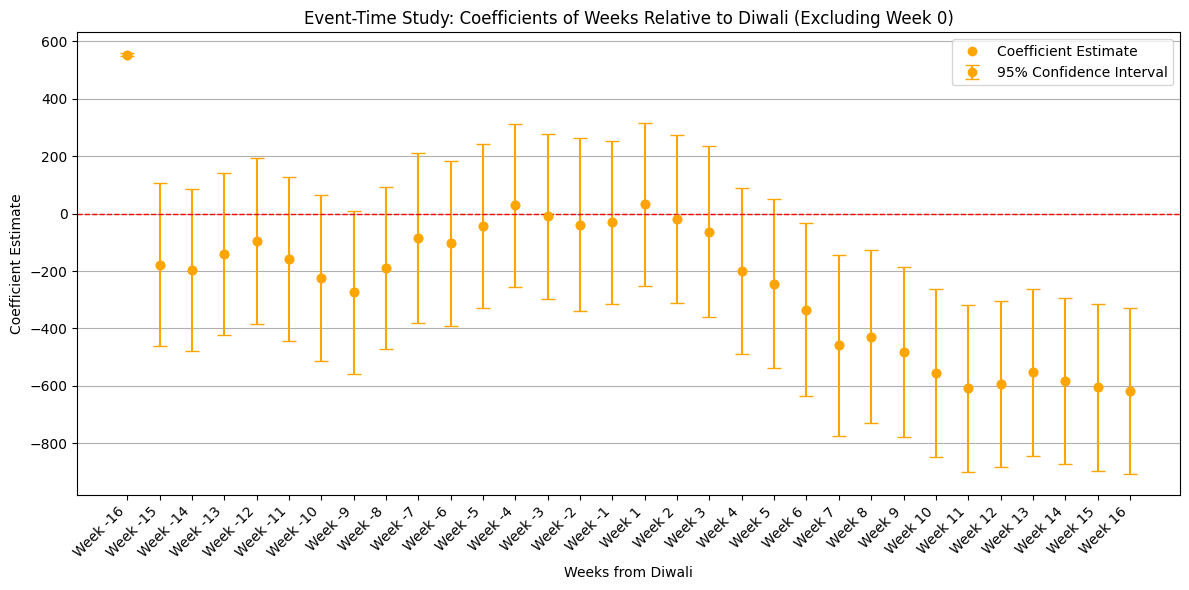

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data
url_N50HD = 'https://raw.githubusercontent.com/AdityaGhatty/Datascience/refs/heads/main/Nifty%2050%20Historical%20Data.csv'
N50 = pd.read_csv(url_N50HD)

# Convert 'Date' column to datetime
N50['Date'] = pd.to_datetime(N50['Date'], errors='coerce')

# Function to convert strings with 'M' or 'B' to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        if 'M' in value:
            return float(value.replace('M', '').replace(',', '').strip()) * 1e6
        elif 'B' in value:
            return float(value.replace('B', '').replace(',', '').strip()) * 1e9
        elif '%' in value:  # Handle percentage values
            return float(value.replace('%', '').strip()) / 100  # Convert to decimal
        else:
            return float(value.replace(',', '').strip())
    return value

# Remove commas from numeric columns and convert to numeric
numeric_columns = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
for col in numeric_columns:
    N50[col] = N50[col].apply(convert_to_numeric)

# Rename 'Price' to 'Close' for clarity
N50.rename(columns={'Price': 'Close'}, inplace=True)

# List of Diwali dates
diwali_dates = ['2007-11-09', '2008-10-28', '2009-10-17', '2010-11-05',
                '2011-10-26', '2012-11-13', '2013-11-03', '2014-10-23',
                '2015-11-11', '2016-10-30', '2017-10-19', '2018-11-07',
                '2019-10-27', '2020-11-14', '2021-11-04']

# Convert Diwali dates to datetime objects
diwali_dates = pd.to_datetime(diwali_dates)

# Create a DataFrame to hold the week dummy variables
dummy_data = []

# Loop through each row in the DataFrame
for index, row in N50.iterrows():
    # Find the nearest Diwali date
    nearest_diwali = min(diwali_dates, key=lambda x: abs(x - row['Date']))
    distance_weeks = (row['Date'] - nearest_diwali).days // 7  # Distance in weeks

    # Check if the date is outside the 16-week range
    outside_range = 1 if distance_weeks < -16 or distance_weeks > 16 else 0

    # Create dummies for weeks before and after Diwali, excluding week zero
    week_dummies = {f'week_{i}': 1 if distance_weeks == i else 0 for i in range(-16, 17) if i != 0}

    # Create month boolean variables
    month_dummies = {f'is_{row["Date"].strftime("%B").lower()}': 1 if row['Date'].month == i else 0 for i in range(1, 13)}

    # Extract the year from the date
    year = row['Date'].year

    # Create the dummy row
    dummy_row = {
        'Date': row['Date'],
        'Close': row['Close'],
        'outside_range': outside_range,
        'Year': year,
        **week_dummies,
        **month_dummies
    }
    dummy_data.append(dummy_row)

# Create a DataFrame from the dummy data
dummy_df = pd.DataFrame(dummy_data)

# Prepare the regression data
X = dummy_df.drop(columns=['Date', 'Close'])  # Independent variables
X = X.fillna(0)  # Fill NaN values with 0
X = X.astype(int)  # Convert boolean to integers
y = dummy_df['Close']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Run the regression with the updated variables
model = sm.OLS(y, X).fit()

# Print the regression results
print("Regression with month variables, year variable, outside_range, and no week_0:")
print(model.summary())

# Extract coefficients for the week dummy variables for plotting
# We exclude the first two entries, which are the constant and 'outside_range'
coefficients = model.params[2:34]  # Adjust the range to match the week dummy variables
confidence_intervals = model.conf_int()[2:34]  # Get the confidence intervals for the same range

# Create the week labels from -16 to +16, excluding 0 (32 weeks in total)
week_labels = [f"Week {i}" for i in range(-16, 17) if i != 0]

# Check to ensure the number of labels matches the number of coefficients
if len(coefficients) == len(week_labels):
    # Create a plot for the coefficients with confidence intervals
    plt.figure(figsize=(12, 6))

    # Plot the coefficients as points
    plt.plot(week_labels, coefficients, 'o', color='orange', label='Coefficient Estimate')

    # Plot the confidence intervals as vertical error bars
    plt.errorbar(week_labels, coefficients,
                 yerr=[coefficients - confidence_intervals[0], confidence_intervals[1] - coefficients],
                 fmt='o', color='orange', capsize=5, label='95% Confidence Interval')

    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Horizontal line at y=0
    plt.title('Event-Time Study: Coefficients of Weeks Relative to Diwali (Excluding Week 0)')
    plt.xlabel('Weeks from Diwali')
    plt.ylabel('Coefficient Estimate')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.legend()
    plt.show()
else:
    print("Mismatch in the number of week labels and coefficients. Please check the regression model output.")